# **Customer Spending Classifier**

## **1. Load the Dataset**
- Import necessary libraries  
- Read the dataset from a local file or an online source  
- Display basic dataset information (`head()`, `describe()`, `info()`)  



In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model  import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report as rep
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import ConfusionMatrixDisplay as cmd

In [22]:
df=pd.read_csv('cust_spend.csv')
df.head()

,Customer ID,Age,Gender,Annual Income,Spending Score
0,d410ea53-6661-42a9-ad3a-f554b05fd2a7,30,Male,151479,89
1,1770b26f-493f-46b6-837f-4237fb5a314e,58,Female,185088,95
2,e81aa8eb-1767-4b77-87ce-1620dc732c5e,62,Female,70912,76
3,9795712a-ad19-47bf-8886-4f997d6046e3,23,Male,55460,57
4,64139426-2226-4cd6-bf09-91bce4b4db5e,24,Male,153752,76


In [23]:
df.describe()

,Age,Annual Income,Spending Score
count,15079.000000,15079.000000,15079.000000
mean,54.191591,109742.880562,50.591617
std,21.119207,52249.425866,28.726977
min,18.000000,20022.000000,1.000000
25%,36.000000,64141.000000,26.000000
50%,54.000000,109190.000000,51.000000
75%,72.000000,155008.000000,75.000000
max,90.000000,199974.000000,100.000000


In [24]:
df.columns

Index(['Customer ID', 'Age', 'Gender', 'Annual Income', 'Spending Score'], dtype='object')

## **2. Exploratory Data Analysis (EDA)**
- Check for missing values  
- Visualize feature distributions (e.g., histograms, boxplots)  
- Analyze relationships between features  



In [25]:
print(df.isnull().sum())


Customer ID       0
Age               0
Gender            0
Annual Income     0
Spending Score    0
dtype: int64


The dataset has no missing values.


In [26]:
#The Customer ID is nor relevant to our analysis, so I'll drop it
df.drop('Customer ID', axis=1, inplace=True)
df.columns

Index(['Age', 'Gender', 'Annual Income', 'Spending Score'], dtype='object')

Since were building a Classification Model, we need to group the target variable, `'Spending Score'`into 3 categories: Low Spender, Medium Spender and High Spender






In [27]:
# Function to classify customers into spending categories
def classify_spending(score):
    if score >= 67:
        return "High Spender"
    elif score >= 34:
        return "Medium Spender"
    else:
        return "Low Spender"

# Apply function to create a new column
df["Spender Category"] = df["Spending Score"].apply(classify_spending)
print(df)


       Age  Gender  Annual Income  Spending Score Spender Category
0       30    Male         151479              89     High Spender
1       58  Female         185088              95     High Spender
2       62  Female          70912              76     High Spender
3       23    Male          55460              57   Medium Spender
4       24    Male         153752              76     High Spender
...    ...     ...            ...             ...              ...
15074   29  Female          97723              30      Low Spender
15075   22    Male          73361              74     High Spender
15076   18  Female         112337              48   Medium Spender
15077   26  Female          94312               5      Low Spender
15078   19    Male          78045               2      Low Spender

[15079 rows x 5 columns]


Add a column that reverse engineers the spending score to give total_spendings from annual income.
This variable was created to boost the models accuracy.

In [28]:
# Calculate Total Spending using Spending Score and Annual Income
df["Total Spending"] = (df["Spending Score"] / 100) * df["Annual Income"]

# Display first few rows to verify
print(df.head())


   Age  Gender  Annual Income  Spending Score Spender Category  Total Spending
0   30    Male         151479              89     High Spender       134816.31
1   58  Female         185088              95     High Spender       175833.60
2   62  Female          70912              76     High Spender        53893.12
3   23    Male          55460              57   Medium Spender        31612.20
4   24    Male         153752              76     High Spender       116851.52


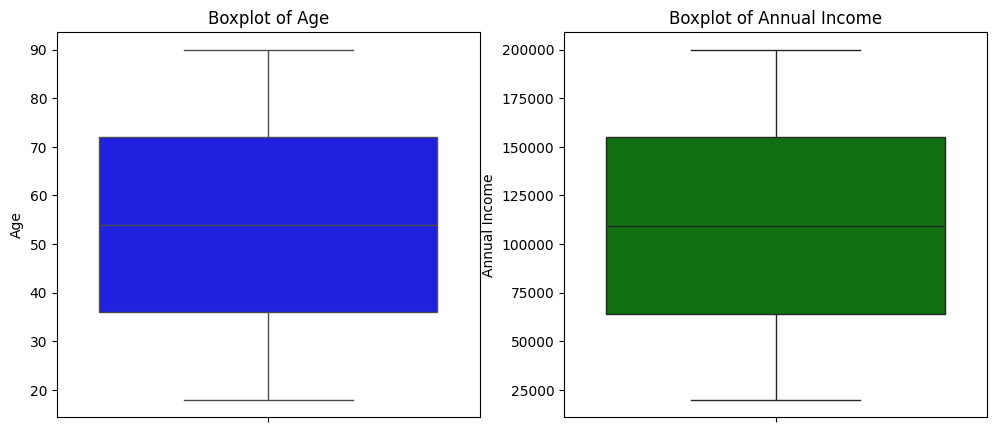

In [29]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df["Age"], color="blue")
plt.title("Boxplot of Age")

plt.subplot(1, 2, 2)
sns.boxplot(y=df["Annual Income"], color="green")
plt.title("Boxplot of Annual Income")

plt.show()


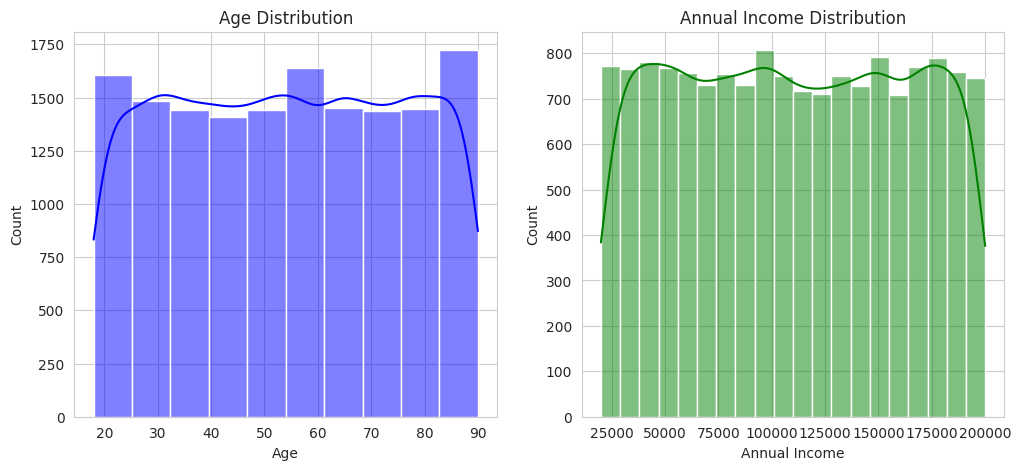

In [30]:
# Plot histograms for Age and Annual Income
sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df["Age"], bins=10, kde=True, color="blue")
plt.title("Age Distribution")
plt.subplot(1, 2, 2)
sns.histplot(df["Annual Income"], bins=20, kde=True, color="green")
plt.title("Annual Income Distribution")

plt.show()


<ipython-input-31-0fe9a2793cab>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Gender", palette="coolwarm")


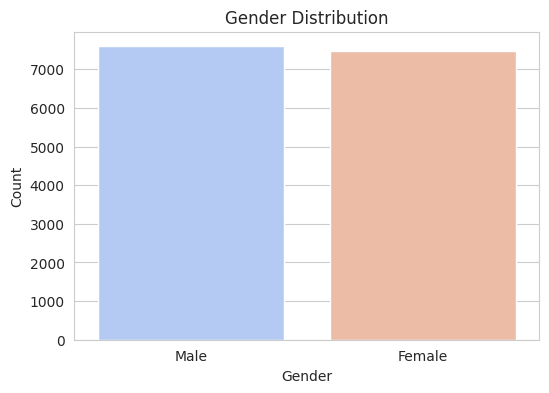

<ipython-input-31-0fe9a2793cab>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Spender Category", palette="viridis", order=["Low Spender", "Medium Spender", "High Spender"])


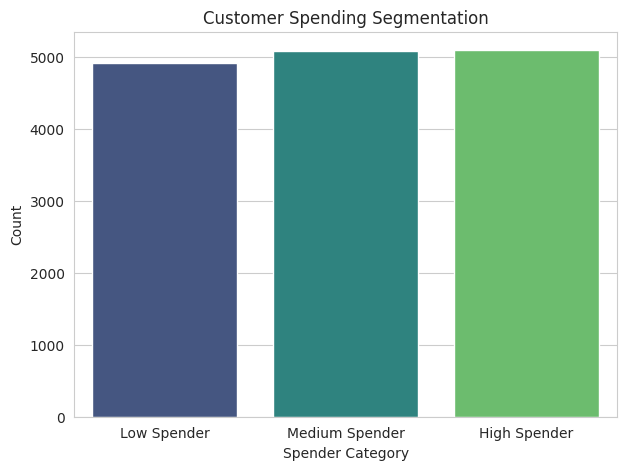

In [31]:
#Gender Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Gender", palette="coolwarm")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

#Spender Category
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="Spender Category", palette="viridis", order=["Low Spender", "Medium Spender", "High Spender"])
plt.title("Customer Spending Segmentation")
plt.xlabel("Spender Category")
plt.ylabel("Count")
plt.show()



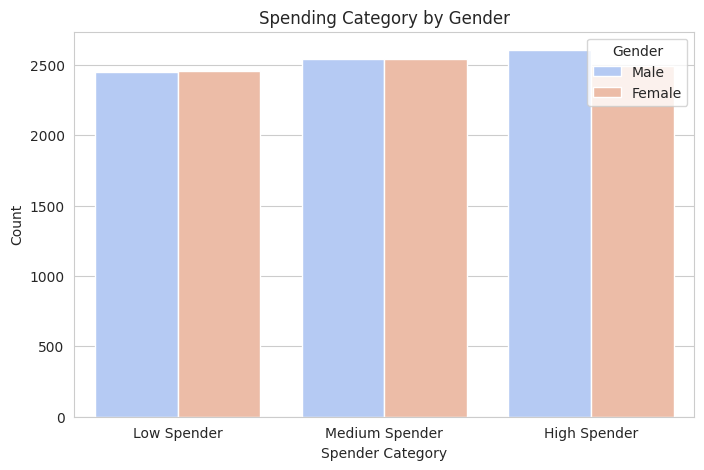

In [32]:
#Spending Category by Gender
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Spender Category", hue="Gender", palette="coolwarm", order=["Low Spender", "Medium Spender", "High Spender"])
plt.title("Spending Category by Gender")
plt.xlabel("Spender Category")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.show()



## **3. Data Preprocessing**
- Handle missing values (e.g., imputation or removal)  
- Convert categorical variables to numerical (e.g., label encoding, one-hot encoding)  
- Feature scaling (e.g., StandardScaler, MinMaxScaler)  


In [33]:
# Label Encoding for Gender
label_encoder = LabelEncoder()
df["Gender"] = label_encoder.fit_transform(df["Gender"])  # Male = 1, Female = 0


In [34]:
label_encoder = LabelEncoder()

# Encode Spending Score as 0, 1, 2
df["Spender Category"] = label_encoder.fit_transform(df["Spender Category"])

# Verify unique values
print(df["Spender Category"].unique())


[0 2 1]


In [35]:
# Selecting numerical features
num_cols = ["Age", "Annual Income", "Spending Score","Total Spending"]
#Min-Max Scaling
minmax_scaler = MinMaxScaler()
df[num_cols] = minmax_scaler.fit_transform(df[num_cols])

print(df.head())

        Age  Gender  Annual Income  Spending Score  Spender Category  \
0  0.166667       1       0.730511        0.888889                 0   
1  0.555556       0       0.917278        0.949495                 0   
2  0.611111       0       0.282798        0.757576                 0   
3  0.069444       1       0.196930        0.565657                 2   
4  0.083333       1       0.743143        0.757576                 0   

   Total Spending  
0        0.677546  
1        0.884003  
2        0.270227  
3        0.158078  
4        0.587122  


In [36]:
df.columns

Index(['Age', 'Gender', 'Annual Income', 'Spending Score', 'Spender Category',
       'Total Spending'],
      dtype='object')


## **4. Split Data into Training and Testing Sets**
- Use `train_test_split()` to divide data into training and test sets  
- Set a `random_state` for reproducibility  


In [37]:
# Define features (X) and target variable (y)
X = df.drop(columns=["Spending Score","Spender Category"])
y = df["Spender Category"]

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset shapes
print("Training Set:", X_train.shape, y_train.shape)
print("Test Set:", X_test.shape, y_test.shape)


Training Set: (12063, 4) (12063,)
Test Set: (3016, 4) (3016,)



## **5. Model Selection & Training**
- Choose an appropriate ML model (e.g., Linear Regression, Decision Tree, SVM, etc.)  
- Fit the model on the training data  


In [38]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


In [39]:
#Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')
f1_rf = f1_score(y_test, y_pred, average='weighted')

In [40]:
#XGBoost Model
xgb_model = XGBClassifier(n_estimators=200, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)




## **6. Model Evaluation**
- Make predictions on the test set  
- Compute evaluation metrics:  
  - **For Regression:** Mean Squared Error (MSE), R² Score  
  - **For Classification:** Accuracy, Precision, Recall, F1-score, Confusion Matrix  


In [41]:
#Evaluation Metrics for Decision Trees Model
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1-score: 0.98


In [42]:
#Evaluation Metrics for Random Forests Model
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest Precision: {precision_rf:.2f}")
print(f"Random Forest Recall: {recall_rf:.2f}")
print(f"Random Forest F1-score: {f1_rf:.2f}")


Random Forest Accuracy: 0.99
Random Forest Precision: 0.99
Random Forest Recall: 0.99
Random Forest F1-score: 0.99


The best Model is the Random Forests Model.

In [44]:
from sklearn.metrics import classification_report as rep
print(rep(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1073
           1       0.99      0.99      0.99       976
           2       0.98      0.98      0.98       967

    accuracy                           0.99      3016
   macro avg       0.99      0.99      0.99      3016
weighted avg       0.99      0.99      0.99      3016



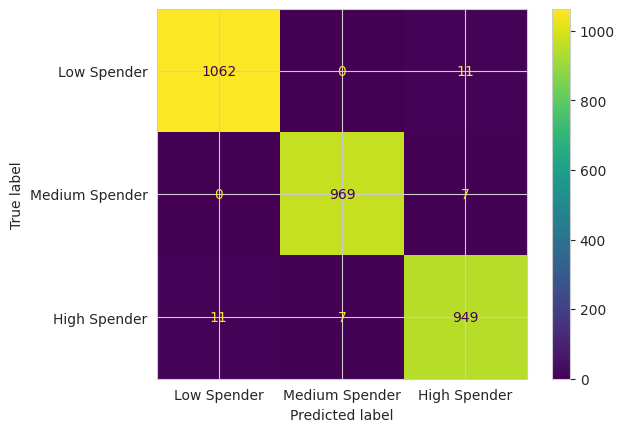

In [45]:
outs = ['Low Spender', 'Medium Spender', 'High Spender']
cm = conf(y_test, y_pred)
disp = cmd(confusion_matrix=cm, display_labels=outs)
disp.plot()


## **7. Model Saving & Deployment**
- Save the trained model using `pickle` or `joblib`  
- Load the saved model and test predictions on new data  


In [47]:
with open("rf_model.pkl", "wb") as file:
    pickle.dump(rf_model, file)

In [48]:
with open("rf_model.pkl", "rb") as file:
    loaded_rf = pickle.load(file)